### Function Approximation in RL
### 260791202   Jianing Sun
## Track 1
### Reproduce five-states and Boyan's Chain experiments by LSTD(lambda) with off-line and recursive formulations

### 1. Boyan's Chain Experiments
### 1.1 Environment

In [3]:
! pip install git+https://github.com/deepmind/pycolab.git

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-yqqtq1e7-build
  Running setup.py install for pycolab ... - \ done


In [0]:
import numpy as np
import pycolab
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
import matplotlib.pyplot as plt

In [0]:
def make_BoyanChain(art):
    return pycolab.ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BoyanChain})

class PlayerSprite_BoyanChain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        super(PlayerSprite_BoyanChain, self).__init__(corner, position, character, impassable='#')

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things  # Unused.
        _, position = self.position

        if actions == 0:  
            if layers["G"][0, position + 1]:
                self._east(board, the_plot) 
                the_plot.add_reward(-2.0)
            else:
                if np.random.rand() > 0.5:  
                    self._east(board, the_plot)
                else:  
                    self._east(board, the_plot)
                    self._east(board, the_plot)

                the_plot.add_reward(-3.0)

        if layers["G"][self.position]:
            the_plot.terminate_episode()

### 1.2 Off-line LSTD(lambda) Experiment

In [0]:
class lstd_params:
    ''' hyperparameters for LSTD algorithms
    d: length of feature vector for states, in boyan chain env, d = 4
    gamma: discount factor
    epsilon: initial A = epsilon * I
    n: number of trajectory
    '''
    def __init__(self):
        self.d = 4

        self.gamma = 1

        self.epsilon = 0.01

        self.n = 3000

        self.la = 0.8

In [0]:
def RMS(l1, l2):
    l = np.array(l1) - np.array(l2)
    rms = np.sqrt(np.sum(l*l) / len(l))
    return rms

In [0]:
def lstd_offline(lstdparams, state_feature, V_pi):
    A = np.eye(lstdparams.d)
    b = np.zeros(lstdparams.d)
    terminal_state = 12
    rms = np.zeros(lstdparams.n)
    for n in range(0, lstdparams.n):
        x = 0
        z = state_feature[0]
        game = make_BoyanChain(BOYAN_CHAIN)
        game.its_showtime()
        while x is not terminal_state:
            obs, reward, gamma = game.play(0)
            state_array = np.array(obs.layers['P'], dtype=int)
            _x = list(state_array[0]).index(1)
            # lstd update
            A += np.outer(z, (np.array(state_feature[x])
                                - lstdparams.gamma * np.array(state_feature[_x])).T)
            b += np.array(z) * reward
            _z = lstdparams.la * np.array(z) + state_feature[_x]
            x = _x
            z = _z
        theta = np.dot(np.linalg.pinv(A), b)
        rms[n] = RMS(theta, V_pi)
        # print(theta)
    return theta, rms

In [0]:
def implementBoyanChain():

    # initialize environment as 13-states boyan chain
    env = BOYAN_CHAIN
    env_width = len(BOYAN_CHAIN[0])
    game = make_BoyanChain(BOYAN_CHAIN)

    # initialize A, b, z
    lstdparams = lstd_params()
    lstdparams.d = 4

    V_pi = [-24, -16, -8, 0]
    state_feature = [[1,    0,    0,    0   ],
                     [0.75, 0.25, 0,    0   ],
                     [0.5,  0.5,  0,    0   ],
                     [0.25, 0.75, 0,    0   ],
                     [0,    1,    0,    0   ],
                     [0,    0.75, 0.25, 0   ],
                     [0,    0.5,  0.5,  0   ],
                     [0,    0.25, 0.75, 0   ],
                     [0,    0,    1,    0   ],
                     [0,    0,    0.75, 0.25],
                     [0,    0,    0.5,  0.5 ],
                     [0,    0,    0.25, 0.75],
                     [0,    0,    0,    0   ]]
    theta, rms = lstd_offline(lstdparams, state_feature, V_pi)

    print('rms:{}.'.format(rms))
    print('theta:{}.'.format(theta))
    plt.figure(1)
    plt.plot(range(0, lstdparams.n), rms[:])
    plt.xlabel('trajectory number')
    plt.ylabel('RMS error')
    plt.show()
    

rms:[5.91862164 3.94546097 2.1533095  ... 0.02319476 0.02319821 0.02271203].
theta:[-24.01184862 -16.00586124  -7.96683989  -0.02808929].


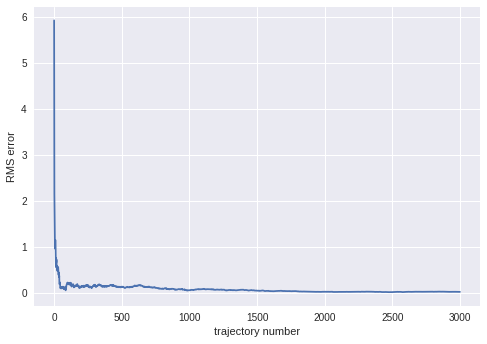

In [17]:
BOYAN_CHAIN = ['P           G']
implementBoyanChain()

After training of 3000 independent trajectories, final theta is, [-24.01184862 -16.00586124  -7.96683989  -0.02808929]. Compared with given optimal theta: [-24, -16, -8, 0], the RMS is only 0.0227 in the end.


### 1.3 Recursive LSTD(lambda) Experiment


In [0]:
def lstd_recursive(lstdparams, state_feature, V_pi):
    A_re = np.eye(lstdparams.d) / lstdparams.epsilon
    b = np.zeros(lstdparams.d)
    terminal_state = 12
    rms = np.zeros(lstdparams.n)
    for n in range(0, lstdparams.n):
        s = 0
        x = state_feature[s]
        z = x
        game = make_BoyanChain(BOYAN_CHAIN)
        game.its_showtime()
        while s is not terminal_state:
            obs, reward, gamma = game.play(0)
            state_array = np.array(obs.layers['P'], dtype=int)
            _s = list(state_array[0]).index(1)
            _x = state_feature[_s]
            v = np.dot(A_re.T, (np.array(x) - lstdparams.gamma * np.array(_x))).reshape(lstdparams.d, 1)
            A_re -= A_re @ np.array(z).reshape(lstdparams.d, 1) @ v.T / (1 + v.T @ z)
            b += np.array(z) * reward
            theta = np.dot(A_re, b)
            z = lstdparams.la * np.array(z) + _x
            s = _s
            x = _x
        rms[n] = RMS(theta, V_pi)
    return theta, rms

In [0]:
def implementBoyanChain():

    # initialize environment as 13-states boyan chain
    env = BOYAN_CHAIN
    env_width = len(BOYAN_CHAIN[0])
    game = make_BoyanChain(BOYAN_CHAIN)

    # initialize A, b, z
    lstdparams = lstd_params()
    lstdparams.d = 4

    optimal = [-24, -16, -8, 0]
    state_feature = [[1,    0,    0,    0   ],
                     [0.75, 0.25, 0,    0   ],
                     [0.5,  0.5,  0,    0   ],
                     [0.25, 0.75, 0,    0   ],
                     [0,    1,    0,    0   ],
                     [0,    0.75, 0.25, 0   ],
                     [0,    0.5,  0.5,  0   ],
                     [0,    0.25, 0.75, 0   ],
                     [0,    0,    1,    0   ],
                     [0,    0,    0.75, 0.25],
                     [0,    0,    0.5,  0.5 ],
                     [0,    0,    0.25, 0.75],
                     [0,    0,    0,    0   ]]

    theta, rms = lstd_recursive(lstdparams, state_feature, optimal)
    print(theta)
    print('rms:{}.'.format(rms))
    plt.figure(2)
    plt.plot(range(0, lstdparams.n), rms[:])
    plt.xlabel('trajectory number')
    plt.ylabel('RMS error')

[-2.40444483e+01 -1.60734272e+01 -8.04418738e+00  1.24329563e-02]
rms:[2.19278441 0.55357954 0.4947521  ... 0.04854852 0.04883011 0.04866805].


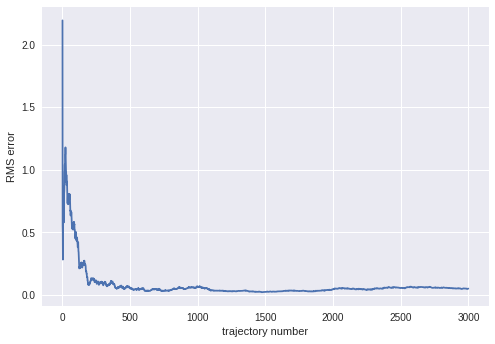

In [20]:
implementBoyanChain()
plt.show()

For recursive LSTD(lambda), it will also find the optimal theta after 3000 independent trajectories. Final theta is [-2.40444483e+01 -1.60734272e+01 -8.04418738e+00  1.24329563e-02]. The RMS figure above indicates that recursive is more instable compared with off-line LSTD algorithm. During first 500 trajectories, recursive LSTD has some vibrations.

### 2. Five-States Experiments
### 2.1 Environment

In [0]:
class PlayerSprite_FiveStates(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        super(PlayerSprite_FiveStates, self).__init__(corner, position, character, impassable='#')

        self.transition_matrix = np.array([
            [0.42, 0.13, 0.14, 0.03, 0.28],
            [0.25, 0.08, 0.16, 0.35, 0.15],
            [0.08, 0.20, 0.33, 0.17, 0.22],
            [0.36, 0.05, 0.00, 0.51, 0.07],
            [0.17, 0.24, 0.19, 0.18, 0.22]
        ])

        self.reward_matrix = np.array([
            [104.66, 29.69, 82.36, 37.49, 68.82],
            [75.86, 29.24, 100.37, 0.31, 35.99],
            [57.68, 65.66, 56.95, 100.44, 47.63],
            [96.23, 14.01, 0.88, 89.77, 66.77],
            [70.35, 23.69, 73.41, 70.70, 85.41]
        ])

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things  # Unused.
        _, position = self.position

        if actions == 0:  
            new_position = np.argmax(np.random.multinomial(n=1, pvals=self.transition_matrix[position, :]))
            the_plot.add_reward(self.reward_matrix[position, new_position])

            self._teleport((0, new_position))

In [0]:
def make_FiveStates(art):
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_FiveStates})


### 2.2 Off-line LSTD(lambda) Experiment

In [0]:
def lstd_offline_five_states(lstdparams, state_feature, threshold=0.01):
    A = np.eye(lstdparams.d)
    b = np.zeros(lstdparams.d)
    diff = 1.0
    last_theta = 0
    t = 0
    x = 0
    z = state_feature[0]
    game = make_FiveStates(FIVE_STATES)
    game.its_showtime()
    while diff >= threshold:
        t += 1
        obs, reward, gamma = game.play(0)
        state_array = np.array(obs.layers['P'], dtype=int)
        _x = list(state_array[0]).index(1)
        # lstd update
        A += np.outer(z, (np.array(state_feature[x])
                            - lstdparams.gamma * np.array(state_feature[_x])).T)
        b += np.array(z) * reward
        _z = lstdparams.la * np.array(z) + state_feature[_x]
        x = _x
        z = _z
        theta = np.dot(np.linalg.pinv(A), b)
        diff = np.sqrt(np.sum((theta - last_theta)*(theta - last_theta)))
        last_theta = theta
    theta = np.dot(np.linalg.pinv(A), b)
    return theta, t

In [0]:
def implementFiveStates():
    # initialize A, b, z
    lstdparams = lstd_params()
    lstdparams.d = 5
    state_feature = [[74.29, 34.61, 73.48, 53.29, 7.79 ],
                     [61.60, 48.07, 34.68, 36.19, 82.02],
                     [97.00, 4.88,  8.51,  87.89, 5.17 ],
                     [41.10, 40.13, 64.63, 92.67, 31.09],
                     [7.76,  79.82, 43.78, 8.56,  61.11]]

    theta, timestep = lstd_offline_five_states(lstdparams, state_feature)
    print("theta: ", theta)
    print("timestep: ", timestep)

In [42]:
FIVE_STATES = ['P    ']
implementFiveStates()

theta:  [ 3.90454942  9.01775954 -1.01249165  2.72396132 -1.1541132 ]
timestep:  64


After 64 timesteps, the difference between successive theta is less than 0.01. Then I stop and output current theta, which is [ 3.90454942  9.01775954 -1.01249165  2.72396132 -1.1541132 ]. 

### 2.3 Recursive LSTD(lambda) Experiment

In [0]:
def lstd_recursive_five_states(lstdparams, state_feature, threshold=0.01):
    A_re = np.eye(lstdparams.d) / lstdparams.epsilon
    b = np.zeros(lstdparams.d)
    diff = 1.0
    last_theta = 0
    t = 0
    s = 0
    x = state_feature[s]
    z = x
    game = make_FiveStates(FIVE_STATES)
    game.its_showtime()
    while diff >= threshold:
        t += 1
        obs, reward, gamma = game.play(0)
        state_array = np.array(obs.layers['P'], dtype=int)
        _s = list(state_array[0]).index(1)
        _x = state_feature[_s]
        v = np.dot(A_re.T, (np.array(x) - lstdparams.gamma * np.array(_x))).reshape(lstdparams.d, 1)
        A_re -= A_re @ np.array(z).reshape(lstdparams.d, 1) @ v.T / (1 + v.T @ z)
        b += np.array(z) * reward
        theta = np.dot(A_re, b)
        diff = np.sqrt(np.sum((theta - last_theta) * (theta - last_theta)))
        last_theta = theta
        z = lstdparams.la * np.array(z) + _x
        s = _s
        x = _x

    theta = np.dot(A_re, b)
    return theta, t

In [0]:
def implementFiveStates():
    # initialize A, b, z
    lstdparams = lstd_params()
    lstdparams.d = 5
    state_feature = [[74.29, 34.61, 73.48, 53.29, 7.79 ],
                     [61.60, 48.07, 34.68, 36.19, 82.02],
                     [97.00, 4.88,  8.51,  87.89, 5.17 ],
                     [41.10, 40.13, 64.63, 92.67, 31.09],
                     [7.76,  79.82, 43.78, 8.56,  61.11]]
    theta, timestep = lstd_recursive_five_states(lstdparams, state_feature)
    print("theta: ", theta)
    print("timestep: ", timestep)

In [47]:
implementFiveStates()

theta:  [ 3.72479157  7.21085883 -0.44565411  2.1590347  -0.7087387 ]
timestep:  29


### 3. Read the section “Equivalence of LSTD(1) and linear regression” in the appendix of Boyan’s paper. Verify this claim empirically by computing the matrices A and b in the “supervised learning” approach. Compare the matrices with those that you would have obtained by LSTD(lambda=1) in part 1 and 2. Check if the solution (value function) found by the “supervised learning” approach matches the solution found by LSTD.

### 3.1 Off-line LSTD

In [0]:
 def equivalence_offline(lstdparams, state_feature):
    A = np.zeros((lstdparams.d, lstdparams.d))
    b = np.zeros(lstdparams.d)
    print(lstdparams.la)
    terminal_state = 12
    x = 0
    z = state_feature[0]
    game = make_BoyanChain(BOYAN_CHAIN)
    game.its_showtime()
    LR_feature = list()
    LR_reward = list()
    while x is not terminal_state:
        obs, reward, gamma = game.play(0)
        state_array = np.array(obs.layers['P'], dtype=int)
        _x = list(state_array[0]).index(1)
        LR_feature.append(state_feature[x])
        LR_reward.append(reward)
        A += np.outer(z, (np.array(state_feature[x])
                          - lstdparams.gamma * np.array(state_feature[_x])).T)
        b += np.array(z) * reward
        _z = lstdparams.la * np.array(z) + state_feature[_x]
        x = _x
        z = _z
    return LR_feature, LR_reward, A, b

In [65]:
state_feature = [[1, 0, 0, 0],
                     [0.75, 0.25, 0, 0],
                     [0.5, 0.5, 0, 0],
                     [0.25, 0.75, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0.75, 0.25, 0],
                     [0, 0.5, 0.5, 0],
                     [0, 0.25, 0.75, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0.75, 0.25],
                     [0, 0, 0.5, 0.5],
                     [0, 0, 0.25, 0.75],
                     [0, 0, 0, 0]]

lstdparams = lstd_params()
lstdparams.d = 4
lstdparams.la = 1
LR_feature, LR_reward, A, b = equivalence_offline(lstdparams, state_feature)
LR_A = np.zeros((lstdparams.d, lstdparams.d))
LR_y = np.zeros(len(LR_feature))
LR_b = np.zeros(lstdparams.d)
print("LR_feature: {}.".format(LR_feature))
print("LR_reward: {}.".format(LR_reward))
print("")

for i in range(0, len(LR_feature)):
    LR_A += LR_feature[i] * np.array(LR_feature[i]).reshape(lstdparams.d, 1)
    LR_y[i] = np.sum(LR_reward[i:])
    LR_b += np.array(LR_feature[i], dtype=float) * LR_y[i]

print("Result from linear regression:")
print("linear regression y: {}.".format(LR_y))
print("linear regression matrix A: {}.".format(LR_A))
print("linear regression matrix b: {}.".format(LR_b))
print("")
print("Result from off-line LSTD(lambda=1):")
print("LSTD matrix A: {}.".format(A))
print("LSTD matrix b: {}.".format(b))

1
LR_feature: [[1, 0, 0, 0], [0.5, 0.5, 0, 0], [0, 1, 0, 0], [0, 0.5, 0.5, 0], [0, 0, 1, 0], [0, 0, 0.75, 0.25], [0, 0, 0.25, 0.75]].
LR_reward: [-3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -2.0].

Result from linear regression:
linear regression y: [-20. -17. -14. -11.  -8.  -5.  -2.].
linear regression matrix A: [[1.25  0.25  0.    0.   ]
 [0.25  1.5   0.25  0.   ]
 [0.    0.25  1.875 0.375]
 [0.    0.    0.375 0.625]].
linear regression matrix b: [-28.5  -28.   -17.75  -2.75].

Result from off-line LSTD(lambda=1):
LSTD matrix A: [[1.25  0.25  0.    0.   ]
 [0.25  1.5   0.25  0.   ]
 [0.    0.25  1.875 0.375]
 [0.    0.    0.375 0.625]].
LSTD matrix b: [-28.5  -28.   -17.75  -2.75].


From above results it is clear that the results of matrix A and b from linear regression and off-line LSTD(lambda) are exactly the same.

### 3.2 Recursive LSTD

In [0]:
def equivalence_recursive(lstdparams, state_feature):
    A_re = np.eye(lstdparams.d)
    A = np.zeros((lstdparams.d, lstdparams.d))
    b = np.zeros(lstdparams.d)
    terminal_state = 12
    LR_feature = list()
    LR_reward = list()

    s = 0
    x = state_feature[s]
    z = x
    game = make_BoyanChain(BOYAN_CHAIN)
    game.its_showtime()
    while s is not terminal_state:
        obs, reward, gamma = game.play(0)
        state_array = np.array(obs.layers['P'], dtype=int)
        _s = list(state_array[0]).index(1)
        _x = state_feature[_s]
        LR_feature.append(state_feature[s])
        LR_reward.append(reward)
        v = np.dot(A_re.T, (np.array(x) - lstdparams.gamma * np.array(_x))).reshape(lstdparams.d, 1)
        A_re -= A_re @ np.array(z).reshape(lstdparams.d, 1) @ v.T / (1 + v.T @ z)
        A += np.outer(z, (np.array(state_feature[s])
                          - lstdparams.gamma * np.array(state_feature[_s])).T)
        b += np.array(z) * reward
        z = lstdparams.la * np.array(z) + _x
        s = _s
        x = _x
    return LR_feature, LR_reward, A, b

In [68]:
LR_feature, LR_reward, A, b = equivalence_recursive(lstdparams, state_feature)
LR_A = np.zeros((lstdparams.d, lstdparams.d))
LR_y = np.zeros(len(LR_feature))
LR_b = np.zeros(lstdparams.d)
print("LR_feature: {}.".format(LR_feature))
print("LR_reward: {}.".format(LR_reward))
print("")

for i in range(0, len(LR_feature)):
    LR_A += LR_feature[i] * np.array(LR_feature[i]).reshape(lstdparams.d, 1)
    LR_y[i] = np.sum(LR_reward[i:])
    LR_b += np.array(LR_feature[i], dtype=float) * LR_y[i]

print("Result from linear regression:")
print("linear regression y: {}.".format(LR_y))
print("linear regression matrix A: {}.".format(LR_A))
print("linear regression matrix b: {}.".format(LR_b))
print("")
print("Result from off-line LSTD(lambda=1):")
print("LSTD matrix A: {}.".format(A))
print("LSTD matrix b: {}.".format(b))

LR_feature: [[1, 0, 0, 0], [0.75, 0.25, 0, 0], [0.25, 0.75, 0, 0], [0, 1, 0, 0], [0, 0.5, 0.5, 0], [0, 0, 1, 0], [0, 0, 0.5, 0.5]].
LR_reward: [-3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0].

Result from linear regression:
linear regression y: [-21. -18. -15. -12.  -9.  -6.  -3.].
linear regression matrix A: [[1.625 0.375 0.    0.   ]
 [0.375 1.875 0.25  0.   ]
 [0.    0.25  1.5   0.25 ]
 [0.    0.    0.25  0.25 ]].
linear regression matrix b: [-38.25 -32.25 -12.    -1.5 ].

Result from off-line LSTD(lambda=1):
LSTD matrix A: [[1.625 0.375 0.    0.   ]
 [0.375 1.875 0.25  0.   ]
 [0.    0.25  1.5   0.25 ]
 [0.    0.    0.25  0.25 ]].
LSTD matrix b: [-38.25 -32.25 -12.    -1.5 ].
